# Analyze data

## Import and merge data

In [1]:
import pandas as pd

In [2]:
# Metadata from Citations
metadata_raw = pd.read_csv("../data/raw/literature_review_meta_data.csv")

In [3]:
metadata_columns_include = ["Item Type", "Publication Year", "Author", "Title", "Publication Title", "Publisher",
                            "Place", "Editor", "Conference Name"]

In [4]:
metadata = metadata_raw[metadata_columns_include]

In [5]:
# Coding results from literature
data_raw = pd.read_excel("../data/interim/literature_coding_results.xlsx")

In [6]:
# Merge data
data = pd.merge(metadata, data_raw, how = "left", left_on='Title', right_on='article_name')

## Analyze metadata

### Graphic Publication per Year

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Prepare dataset
subset_year_category = data[["Publication Year", "article_topic"]]
subset_year = data[["Publication Year"]]
subset_year["article_topic"] = "All Publication"
visualization_year_category = subset_year_category.append(subset_year).sort_values("article_topic").reset_index(drop = True).dropna()

/var/folders/zx/r0fw_tq95g13lvmt5x8bp_vr0000gn/T/ipykernel_70090/4168712211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_year["article_topic"] = "All Publication"


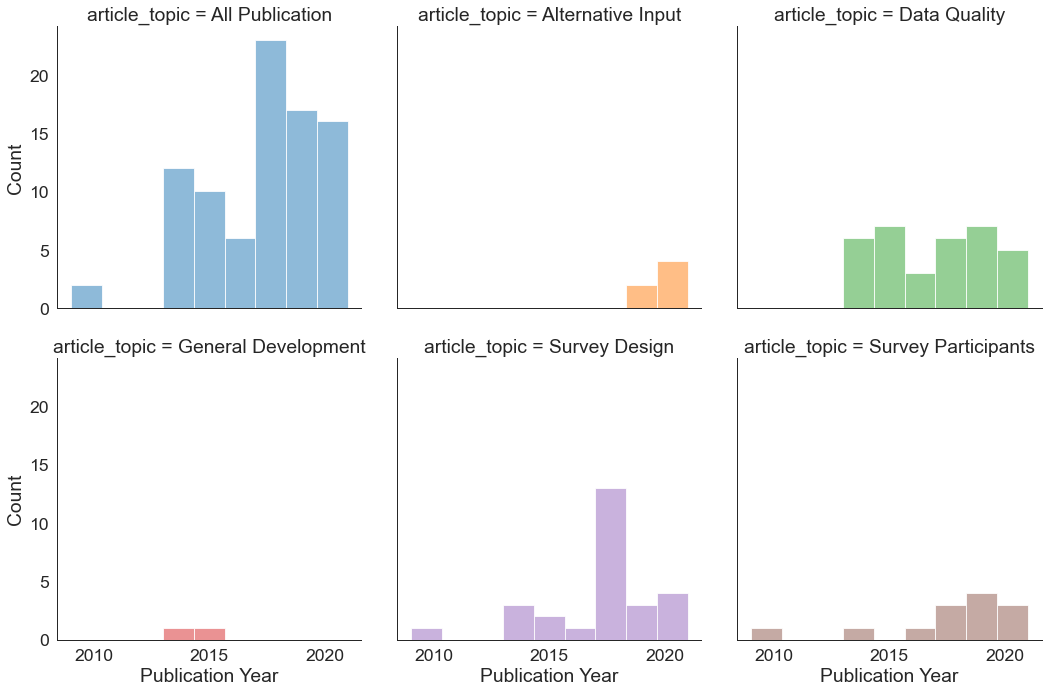

In [9]:
sns.set_style('white')
sns.set_context('paper', font_scale = 2)
plot = sns.displot(data=visualization_year_category, x= "Publication Year",
            hue="article_topic", col = "article_topic", col_wrap=3,legend = False
           )

### Graphic Survey per Year

In [10]:
data_survey_year = data[data.survey_year.notna()]

In [11]:
data_survey_year.groupby("survey_year").size()

survey_year
2005.0     1
2007.0     1
2010.0     1
2011.0     3
2012.0     6
2013.0     8
2014.0     7
2015.0    11
2016.0     8
2017.0     9
2018.0     6
2019.0     1
dtype: int64

In [12]:
data_survey_year.survey_year.mean()

2014.5483870967741

In [13]:
data_survey_year.groupby("Publication Year").size()

Publication Year
2009     1
2010     1
2013     3
2014     6
2015     5
2016     4
2017     6
2018     8
2019    13
2020     7
2021     8
dtype: int64

In [14]:
data_survey_year["Publication Year"].mean()

2017.4516129032259

In [15]:
data_survey_year["Publication Year"].mean()-data_survey_year.survey_year.mean()

2.903225806451701

### Overview of Journal

In [16]:
data.groupby("Publication Title").size().sort_values(ascending=False)

Publication Title
Social Science Computer Review                                                27
International Journal of Market Research                                       8
Survey Research Methods                                                        6
methods, data, analyses                                                        5
Public Opinion Quarterly                                                       4
International Journal of Social Research Methodology                           4
Journal of Survey Statistics and Methodology                                   4
Field methods                                                                  3
Sociological Methods & Research                                                2
Internet Research                                                              2
Quality & Quantity                                                             2
Transportation Research Procedia                                               1
The Patien

### Overview of authors

In [17]:
authors = pd.DataFrame({"author":[j for i in metadata["Author"].str.split("; ") for j in i]})
publication_per_author = authors.groupby("author").size().sort_values(ascending = False)
print(publication_per_author.head(25))

author
Couper, Mick P.        15
Revilla, Melanie       14
Toepoel, Vera           8
Lugtig, Peter           7
Mavletova, Aigul        6
Antoun, Christopher     6
Bosch, Oriol J.         5
De Bruijne, Marika      3
Ochoa, Carlos           3
Keusch, Florian         3
Wang, Lin               3
Buskirk, Trent D.       3
Schlosser, Stephan      3
Toninelli, Daniele      3
Höhne, Jan K.           3
Wijnant, Arnaud         3
Roßmann, Joss           3
Yan, Ting               3
Gummer, Tobias          2
Ha, Louisa,             2
Katz, Jonathan          2
Haan, Marieke           2
Paura, Ezequiel         2
Figueroa, Ivonne J.     2
Falcone, Brian          2
dtype: int64


### Overview of Countries

In [18]:
data.groupby("survey_country").size()

survey_country
European Union Member and Accession Countries     1
Germany                                          14
Italy                                             1
Netherlands                                      11
Norway                                            1
Norwegia                                          1
Russia                                            5
South Korea                                       1
Spain                                             9
Spanish Speaking Countries                        1
UK                                                2
USA                                              20
['China', 'USA']                                  1
['Spain', 'Mexico']                               2
['UK', 'Australia', 'Canda']                      1
dtype: int64

In [19]:
countries = data.survey_country.values.tolist()

In [20]:
# We add countries that are part of multiple countries surveys
countries_to_add = ["China", "USA", "Spain", "Mexico","Spain", "Mexico", "UK", "Australia", "Canada", "Norway"]
countries_to_drop = ["European Union Member and Accession Countries","['China', 'USA']", "['Spain', 'Mexico']",
                     "['UK', 'Australia', 'Canda']", "Spanish Speaking Countries", "Norwegia"]  

In [21]:
countries_complete = countries + countries_to_add 

In [22]:
countries_for_count = [country for country in countries_complete if country not in countries_to_drop]

In [23]:
country_count = pd.DataFrame({"Country":countries_for_count}).groupby("Country").size()
country_count_df = country_count.reset_index().rename(columns = {0: "Count"})

In [24]:
country_count_df.replace({"USA": "United States of America",
                          "UK": " United Kingdom"}, inplace = True)

In [25]:
import geopandas as gpd
import folium

In [26]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [27]:
mapped = world.merge(country_count_df, how="left", left_on=['name'], right_on=['Country'])

In [28]:
mapped = mapped.fillna(0)

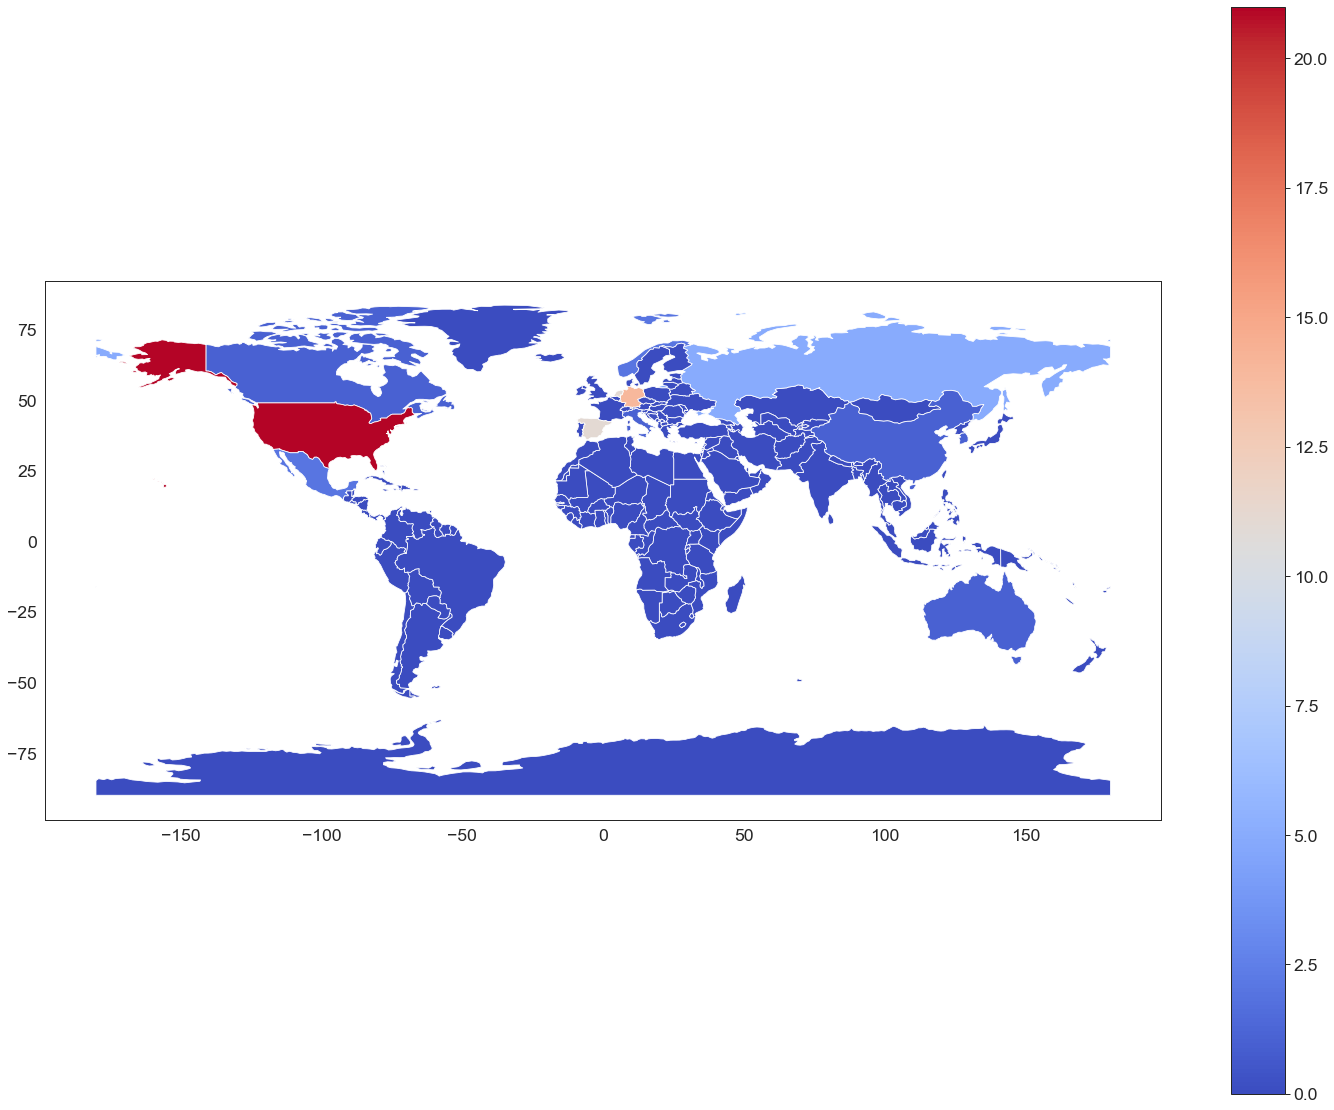

In [29]:
mapped.plot(column='Count',
           figsize=(25, 20),
           legend=True,cmap='coolwarm')

### Survey Operator

In [30]:
data.groupby("survey_operator").size().sort_values(ascending = False)

survey_operator
Author                                                                                                                                 14
Netquest                                                                                                                               12
CentERdata                                                                                                                              8
Online Market Intelligence                                                                                                              5
KnowledgePanel                                                                                                                          3
GESIS                                                                                                                                   3
German Longitudinal Election Study                                                                                                      3
SurveyMonkey Audie

### Data Quality

In [36]:
def create_data_set(df, topic):
    interesting_columns = ["Item Type", "Publication Year", "Author", "Title", "Publication Title", "Publisher",
                           "Conference Name", "article_name", "article_topic", "article_type", "survey_data",
                           "survey_participants_number", "survey_country", "survey_operator", "survey_mode",
                           "survey_population", "survey_participants_representative", 
                           "survey_design_mobile_adapted", "survey_year", "survey_participants_number_mobile",
                           "survey_participants_source", "survey_incentive"]
    interesting_columns.append(topic)
    df_columns = df[interesting_columns]
    df_of_interest = df_columns[df_columns[topic].notna()]
    write_location = "../data/processed/" + topic + ".xlsx"
    df_of_interest.to_excel(write_location, index=False)
    return df_of_interest

#### Analyze Completion Time

In [37]:
completion_time = create_data_set(data, "mobile_completion_time_higher")

In [38]:
completion_time

,Item Type,Publication Year,Author,Title,Publication Title,Publisher,Conference Name,article_name,article_topic,article_type,...,survey_operator,survey_mode,survey_population,survey_participants_representative,survey_design_mobile_adapted,survey_year,survey_participants_number_mobile,survey_participants_source,survey_incentive,mobile_completion_time_higher
0,journalArticle,2017,"Revilla, Melanie; Toninelli, Daniele; Ochoa, C...",An experiment comparing grids and item-by-item...,Telematics & Informatics,NaN,NaN,An experiment comparing grids and item-by-item...,Survey Design,Research Article,...,Netquest,Web Survey,Adults Smartphone and PC User,NaN,"[True, False]",2015.0,NaN,NaN,NaN,True
2,journalArticle,2019,"Ha, Louisa,; Zhang, Chenjie",Are computers better than smartphones for web ...,Online Information Review,NaN,NaN,Are computers better than smartphones for web ...,Data Quality,Research Article,...,Author,Web Survey,Students,False,True,2015.0,NaN,NaN,NaN,False
4,journalArticle,2017,"Revilla, Melanie",Are There Differences Depending on the Device ...,Field methods,NaN,NaN,Are There Differences Depending on the Device ...,Survey Design,Research Article,...,Netquest,Web Survey,Spanish Adults,True,"[True, False]",2015.0,NaN,NaN,NaN,True
8,journalArticle,2013,"De Bruijne, Marika; Wijnant, Arnaud",Comparing Survey Results Obtained via Mobile D...,Social Science Computer Review,NaN,NaN,Comparing Survey Results Obtained via Mobile D...,Data Quality,Research Article,...,CentERdata,Web Survey,Dutch-speaking Adults,True,True,2012.0,NaN,NaN,NaN,True
10,journalArticle,2021,"Weigold, Arne; Weigold, Ingrid K.; Dykema, Ste...",Computerized Device Equivalence: A Comparison ...,International Journal of Human-Computer Intera...,NaN,NaN,Computerized Device Equivalence: A Comparison ...,Data Quality,Research Article,...,Author,Web Survey,Students,False,NaN,NaN,56,NaN,NaN,False
12,journalArticle,2020,"Ha, Louisa,; Zhang, Chenjie; Jiang, Weiwei",Data quality comparison between computers and ...,Internet Research,NaN,NaN,Data quality comparison between computers and ...,Data Quality,Research Article,...,Author,"['CASI', 'Web Survey']",Students,False,True,2015.0,NaN,NaN,False,False
13,journalArticle,2013,"Mavletova, Aigul",Data Quality in PC and Mobile Web Surveys,Social Science Computer Review,NaN,NaN,Data Quality in PC and Mobile Web Surveys,Data Quality,Research Article,...,Online Market Intelligence,Web Survey,Russian Mobile Web User (18+),True,NaN,2011.0,NaN,Volunteer Online Access Panel,NaN,True
19,journalArticle,2019,"Hartman, John D.; Craig, Benjamin M.",Does Device or Connection Type Affect Health P...,The Patient-Patient-Centered Outcomes Research,NaN,NaN,Does Device or Connection Type Affect Health P...,Data Quality,Research Article,...,EuroQoL Research Foundation,Web Survey,American Adults,True,NaN,NaN,329,NaN,NaN,True
21,journalArticle,2015,"Liebe, Ulf; Glenk, Klaus; Oehlmann, Malte; Mey...",Does the use of mobile devices (tablets and sm...,Journal of choice modelling,NaN,NaN,Does the use of mobile devices (tablets and sm...,Data Quality,Research Article,...,NaN,NaN,NaN,True,True,2012.0,NaN,NaN,NaN,True
23,journalArticle,2017,"Antoun, Christopher; Couper, Mick P.; Conrad, ...",EFFECTS OF MOBILE VERSUS PC WEB ON SURVEY RESP...,Public Opinion Quarterly,NaN,NaN,EFFECTS OF MOBILE VERSUS PC WEB ON SURVEY RESP...,Data Quality,Research Article,...,CentERdata,Web Survey,Dutch Adults,True,True,2013.0,NaN,LISS Panel,NaN,True


#### Analyze Missing items Rate

In [40]:
create_data_set(data, "mobile_missing_items_rate_higher")

,Item Type,Publication Year,Author,Title,Publication Title,Publisher,Conference Name,article_name,article_topic,article_type,...,survey_operator,survey_mode,survey_population,survey_participants_representative,survey_design_mobile_adapted,survey_year,survey_participants_number_mobile,survey_participants_source,survey_incentive,mobile_missing_items_rate_higher
4,journalArticle,2017,"Revilla, Melanie",Are There Differences Depending on the Device ...,Field methods,NaN,NaN,Are There Differences Depending on the Device ...,Survey Design,Research Article,...,Netquest,Web Survey,Spanish Adults,True,"[True, False]",2015.0,NaN,NaN,NaN,1.0
6,journalArticle,2019,"Erens, Bob; Manacorda, Tommaso; Gosling, Jenni...",Comparing data quality from personal computers...,Social Research Practice,NaN,NaN,Comparing data quality from personal computers...,Data Quality,Research Article,...,Improving General Practice Service Survey,Web Survey,Practioner,False,False,2017.0,1604,NaN,NaN,0.0
7,journalArticle,2018,"Revilla, Melanie; Couper, Mick P.",Comparing Grids With Vertical and Horizontal I...,Social Science Computer Review,NaN,NaN,Comparing Grids With Vertical and Horizontal I...,Survey Design,Research Article,...,Netquest,Web Survey,Adults Smartphone and PC User,True,True,2016.0,NaN,NaN,NaN,0.0
25,journalArticle,2019,"Lee, Hana; Kim, Sunwoong; Couper, Mick P.; Woo...","Experimental comparison of PC web, smartphone ...",Social Science Computer Review,NaN,NaN,"Experimental comparison of PC web, smartphone ...",Data Quality,Research Article,...,Dongguk University Student Life Survey,Web Survey,Students,True,True,2014.0,1000,NaN,NaN,0.0
40,journalArticle,2014,"Buskirk, Trent D.; Andrus, Charles H.",Making Mobile Browser Surveys Smarter: Results...,Field methods,NaN,NaN,Making Mobile Browser Surveys Smarter: Results...,Data Quality,Research Article,...,Survey Sampling International Incorporated,Web Survey,iPhone Owner,True,True,2011.0,NaN,NaN,NaN,0.0
51,journalArticle,2020,"Daikeler, Jessica; Bach, Ruben L.; Silber, Hen...",Motivated Misreporting in Smartphone Surveys,Social Science Computer Review,NaN,NaN,Motivated Misreporting in Smartphone Surveys,Data Quality,Research Article,...,GESIS,Web Survey,German Adults,True,True,2018.0,1612,German Nonprobability Online Access Panel,NaN,1.0
63,journalArticle,2018,"Toepoel, Vera; Funke, Frederik","Sliders, visual analogue scales, or buttons: I...",Mathematical Population Studies,NaN,NaN,"Sliders, visual analogue scales, or buttons: I...",Survey Design,Research Article,...,KnowledgePanel,Web Survey,Dutch older than 15,True,NaN,2014.0,NaN,NaN,NaN,1.0
72,journalArticle,2015,"Struminskaya, Bella; Weyandt, Kai; Bosnjak, Mi...",The effects of questionnaire completion using ...,"methods, data, analyses",NaN,NaN,The effects of questionnaire completion using ...,Data Quality,Research Article,...,GESIS,Web Survey,German Adults,True,False,2014.0,NaN,German Nonprobability Online Access Panel,NaN,1.0
73,journalArticle,2016,"Lugtig, Peter; Toepoel, Vera","The Use of PCs, Smartphones, and Tablets in a ...",Social Science Computer Review,NaN,NaN,"The Use of PCs, Smartphones, and Tablets in a ...",Data Quality,Research Article,...,CentERdata,Web Survey,Dutch Adults,True,True,2013.0,NaN,LISS Panel,NaN,1.0
78,journalArticle,2018,"Tourangeau, Roger; Sun, Hanyu; Yan, Ting; Mait...",Web Surveys by Smartphones and Tablets: Effect...,Social Science Computer Review,NaN,NaN,Web Surveys by Smartphones and Tablets: Effect...,Data Quality,Research Article,...,Author,Face-To-Face Survey,Adult Household Population,False,False,2015.0,NaN,Address Based Sample,NaN,0.0


#### Analyze Text Answer shorter

In [41]:
create_data_set(data, "mobile_text_answer_shorter")

,Item Type,Publication Year,Author,Title,Publication Title,Publisher,Conference Name,article_name,article_topic,article_type,...,survey_operator,survey_mode,survey_population,survey_participants_representative,survey_design_mobile_adapted,survey_year,survey_participants_number_mobile,survey_participants_source,survey_incentive,mobile_text_answer_shorter
9,journalArticle,2014,"Wells, Tom; Bailey, Justin T.; Link, Michael W.",Comparison of Smartphone and Online Computer S...,Social Science Computer Review,NaN,NaN,Comparison of Smartphone and Online Computer S...,Data Quality,Research Article,...,KnowledgePanel,Mobile Web Survey,American Adults,True,True,2011.0,NaN,NaN,NaN,True
13,journalArticle,2013,"Mavletova, Aigul",Data Quality in PC and Mobile Web Surveys,Social Science Computer Review,NaN,NaN,Data Quality in PC and Mobile Web Surveys,Data Quality,Research Article,...,Online Market Intelligence,Web Survey,Russian Mobile Web User (18+),True,NaN,2011.0,NaN,Volunteer Online Access Panel,NaN,True
39,journalArticle,2015,"Lambert, Amber D.; Miller, Angie L.",Living with Smartphones: Does Completion Devic...,Research in Higher Education,NaN,NaN,Living with Smartphones: Does Completion Devic...,Data Quality,Research Article,...,Strategic National Arts Alumni Project,Web Survey,Alumni of Arts Education,False,NaN,2012.0,NaN,NaN,NaN,True
40,journalArticle,2014,"Buskirk, Trent D.; Andrus, Charles H.",Making Mobile Browser Surveys Smarter: Results...,Field methods,NaN,NaN,Making Mobile Browser Surveys Smarter: Results...,Data Quality,Research Article,...,Survey Sampling International Incorporated,Web Survey,iPhone Owner,True,True,2011.0,NaN,NaN,NaN,False
43,journalArticle,2018,"Schlosser, Stephan; Mays, Anja",Mobile and Dirty: Does Using Mobile Devices Af...,Social Science Computer Review,NaN,NaN,Mobile and Dirty: Does Using Mobile Devices Af...,Data Quality,Research Article,...,Author,Web Survey,Students,False,True,2014.0,NaN,NaN,NaN,False
47,journalArticle,2021,"Zou, Suiwen; Tan, Karen P.; Liu, Hongbo; Li, X...",Mobile vs. PC: the device mode effects on tour...,Current Issues in Tourism,NaN,NaN,Mobile vs. PC: the device mode effects on tour...,Data Quality,Research Article,...,"['Online Survey Company', 'Chinese Survey Comp...",Web Survey,"['American Leisure Tourist', 'Chinese Adults']",NaN,NaN,2017.0,"[1283, 861]",NaN,NaN,"[None, False]"
53,journalArticle,2016,"Revilla, Melanie; Ochoa, Carlos",Open narrative questions in PC and smartphones...,Quality & Quantity,NaN,NaN,Open narrative questions in PC and smartphones...,Data Quality,Research Article,...,Netquest,Web Survey,Spanish Adults,False,"[True, False]",2015.0,NaN,NaN,NaN,True
56,journalArticle,2021,"Toepoel, Vera; Mathon, Karlijn; Tussenbroek, P...",Probing in online mixed-device surveys: Is a r...,Bulletin of Sociological Methodology/Bulletin ...,NaN,NaN,Probing in online mixed-device surveys: Is a r...,Alternative Input,Research Article,...,Amazon Mechanical Turk,"['Web Survey', 'Messenger']",American Adults,False,True,2018.0,NaN,NaN,NaN,True
72,journalArticle,2015,"Struminskaya, Bella; Weyandt, Kai; Bosnjak, Mi...",The effects of questionnaire completion using ...,"methods, data, analyses",NaN,NaN,The effects of questionnaire completion using ...,Data Quality,Research Article,...,GESIS,Web Survey,German Adults,True,False,2014.0,NaN,German Nonprobability Online Access Panel,NaN,True
73,journalArticle,2016,"Lugtig, Peter; Toepoel, Vera","The Use of PCs, Smartphones, and Tablets in a ...",Social Science Computer Review,NaN,NaN,"The Use of PCs, Smartphones, and Tablets in a ...",Data Quality,Research Article,...,CentERdata,Web Survey,Dutch Adults,True,True,2013.0,NaN,LISS Panel,NaN,True


#### Analyze Avoid Text Answer

In [42]:
create_data_set(data, "mobile_text_answer_avoid_more")

,Item Type,Publication Year,Author,Title,Publication Title,Publisher,Conference Name,article_name,article_topic,article_type,...,survey_operator,survey_mode,survey_population,survey_participants_representative,survey_design_mobile_adapted,survey_year,survey_participants_number_mobile,survey_participants_source,survey_incentive,mobile_text_answer_avoid_more
6,journalArticle,2019,"Erens, Bob; Manacorda, Tommaso; Gosling, Jenni...",Comparing data quality from personal computers...,Social Research Practice,NaN,NaN,Comparing data quality from personal computers...,Data Quality,Research Article,...,Improving General Practice Service Survey,Web Survey,Practioner,False,False,2017.0,1604,NaN,NaN,1.0
9,journalArticle,2014,"Wells, Tom; Bailey, Justin T.; Link, Michael W.",Comparison of Smartphone and Online Computer S...,Social Science Computer Review,NaN,NaN,Comparison of Smartphone and Online Computer S...,Data Quality,Research Article,...,KnowledgePanel,Mobile Web Survey,American Adults,True,True,2011.0,NaN,NaN,NaN,0.0
12,journalArticle,2020,"Ha, Louisa,; Zhang, Chenjie; Jiang, Weiwei",Data quality comparison between computers and ...,Internet Research,NaN,NaN,Data quality comparison between computers and ...,Data Quality,Research Article,...,Author,"['CASI', 'Web Survey']",Students,False,True,2015.0,NaN,NaN,False,1.0
23,journalArticle,2017,"Antoun, Christopher; Couper, Mick P.; Conrad, ...",EFFECTS OF MOBILE VERSUS PC WEB ON SURVEY RESP...,Public Opinion Quarterly,NaN,NaN,EFFECTS OF MOBILE VERSUS PC WEB ON SURVEY RESP...,Data Quality,Research Article,...,CentERdata,Web Survey,Dutch Adults,True,True,2013.0,NaN,LISS Panel,NaN,0.0
36,journalArticle,2014,"De Bruijne, Marika; Wijnant, Arnaud",Improving Response Rates and Questionnaire Des...,Public Opinion Quarterly,NaN,NaN,Improving Response Rates and Questionnaire Des...,Survey Design,Research Article,...,CentERdata,Web Survey,Dutch-speaking Adults,True,True,2013.0,NaN,LISS Panel,NaN,0.0
43,journalArticle,2018,"Schlosser, Stephan; Mays, Anja",Mobile and Dirty: Does Using Mobile Devices Af...,Social Science Computer Review,NaN,NaN,Mobile and Dirty: Does Using Mobile Devices Af...,Data Quality,Research Article,...,Author,Web Survey,Students,False,True,2014.0,NaN,NaN,NaN,0.0
53,journalArticle,2016,"Revilla, Melanie; Ochoa, Carlos",Open narrative questions in PC and smartphones...,Quality & Quantity,NaN,NaN,Open narrative questions in PC and smartphones...,Data Quality,Research Article,...,Netquest,Web Survey,Spanish Adults,False,"[True, False]",2015.0,NaN,NaN,NaN,0.0
72,journalArticle,2015,"Struminskaya, Bella; Weyandt, Kai; Bosnjak, Mi...",The effects of questionnaire completion using ...,"methods, data, analyses",NaN,NaN,The effects of questionnaire completion using ...,Data Quality,Research Article,...,GESIS,Web Survey,German Adults,True,False,2014.0,NaN,German Nonprobability Online Access Panel,NaN,1.0
80,journalArticle,2014,"Toepoel, Vera; Lugtig, Peter",What Happens if You Offer a Mobile Option to Y...,Social Science Computer Review,NaN,NaN,What Happens if You Offer a Mobile Option to Y...,Data Quality,Research Article,...,Author,Web Survey,Dutch Internet User (18+),True,True,2012.0,NaN,Random Digit Dialling,NaN,0.0


#### Analyze Straightlining

In [43]:
create_data_set(data, "mobile_straightlining_more")

,Item Type,Publication Year,Author,Title,Publication Title,Publisher,Conference Name,article_name,article_topic,article_type,...,survey_operator,survey_mode,survey_population,survey_participants_representative,survey_design_mobile_adapted,survey_year,survey_participants_number_mobile,survey_participants_source,survey_incentive,mobile_straightlining_more
6,journalArticle,2019,"Erens, Bob; Manacorda, Tommaso; Gosling, Jenni...",Comparing data quality from personal computers...,Social Research Practice,NaN,NaN,Comparing data quality from personal computers...,Data Quality,Research Article,...,Improving General Practice Service Survey,Web Survey,Practioner,False,False,2017.0,1604,NaN,NaN,0.0
33,journalArticle,2018,"Mavletova, Aigul; Couper, Mick P.; Lebedev, Da...",Grid and Item-by-Item Formats in PC and Mobile...,Social Science Computer Review,NaN,NaN,Grid and Item-by-Item Formats in PC and Mobile...,Survey Design,Research Article,...,Online Market Intelligence,Web Survey,Mobile Internet User,False,True,2016.0,NaN,Volunteer Online Access Panel,NaN,0.0
58,journalArticle,2019,"Lugtig, Peter; Toepoel, Vera; Haan, Marieke; Z...",Recruiting Young and Urban Groups into a Proba...,"methods, data, analyses",NaN,NaN,Recruiting Young and Urban Groups into a Proba...,Survey Participants,Research Article,...,I&O Research Panel,Web Survey,Dutch Adults,True,"[True, False]",2017.0,2898,NaN,Lottery,0.0
72,journalArticle,2015,"Struminskaya, Bella; Weyandt, Kai; Bosnjak, Mi...",The effects of questionnaire completion using ...,"methods, data, analyses",NaN,NaN,The effects of questionnaire completion using ...,Data Quality,Research Article,...,GESIS,Web Survey,German Adults,True,False,2014.0,NaN,German Nonprobability Online Access Panel,NaN,1.0
78,journalArticle,2018,"Tourangeau, Roger; Sun, Hanyu; Yan, Ting; Mait...",Web Surveys by Smartphones and Tablets: Effect...,Social Science Computer Review,NaN,NaN,Web Surveys by Smartphones and Tablets: Effect...,Data Quality,Research Article,...,Author,Face-To-Face Survey,Adult Household Population,False,False,2015.0,NaN,Address Based Sample,NaN,0.0
79,journalArticle,2017,"Keusch, Florian; Yan, Ting",Web Versus Mobile Web: An Experimental Study o...,Social Science Computer Review,NaN,NaN,Web Versus Mobile Web: An Experimental Study o...,Survey Participants,Research Article,...,Amazon Mechanical Turk,Mobile Web Survey,Adult IPhone User,False,NaN,2014.0,NaN,NaN,NaN,1.0


#### Analyse Quality Dimensions

In [45]:
data_quality = data[data.article_topic == "Data Quality"]

In [60]:
for column in data.columns.sort_values():
    print(column)

Author
Conference Name
Editor
Item Type
Place
Publication Title
Publication Year
Publisher
Title
article_name
article_topic
article_type
input_alternative_android_voice_higher_nonreponse_than_text
input_alternative_android_voice_less_valid_answers_than_text
input_alternative_android_voice_more_characters_than_text
input_alternative_android_voice_more_complicated_than_text
input_alternative_android_voice_more_techical_problems_than_text
input_alternative_android_voice_trust_anonymity_less_than_text
input_alternative_image_taking_lower_compliance_than_image_uploading
input_alternative_ios_voice_higher_nonreponse_than_text
input_alternative_ios_voice_less_characters_than_text
input_alternative_ios_voice_less_valid_answers_than_text
input_alternative_ios_voice_more_complicated_than_text
input_alternative_ios_voice_trust_anonymity_less_than_text
input_alternative_messenger_completion_rate_lower
input_alternative_messenger_completion_time_longer
input_alternative_messenger_shorter_text
input

In [64]:
import re

In [78]:
quality_indicator = [x for x in data.columns.tolist() if re.match("mobile_(?!participant|design).*", x)] 

In [83]:
data[quality_indicator].count().sort_values(ascending = False).head(60)

mobile_completion_time_higher                                                     28
mobile_breakoff_rate_higher                                                       15
mobile_text_answer_shorter                                                        11
mobile_missing_items_rate_higher                                                  11
mobile_text_answer_avoid_more                                                      9
mobile_straightlining_more                                                         6
mobile_non_substantial_anwser_more                                                 4
mobile_satisfaction_lower                                                          4
mobile_completion_rate_lower                                                       4
mobile_primacy_effect_higher                                                       4
mobile_inconsistent_anwsers_more                                                   2
mobile_sensitive_questions_answering_less                        

### Survey Participants

In [86]:
participants_indicator = [x for x in data.columns.tolist() if re.match("mobile_participants_.*", x)] 
data[participants_indicator].count().sort_values(ascending = False).head(60)

mobile_participants_younger                                          11
mobile_participants_more_female                                      10
mobile_participants_education_higher                                  6
mobile_participants_more_mobile                                       5
mobile_participants_less_alone                                        3
mobile_participants_income_higher                                     3
mobile_participants_coverage_bias                                     2
mobile_participants_more_multitasking                                 2
mobile_participants_more_urban                                        2
mobile_participants_less_trust_in_confidentiality                     2
mobile_participants_more_male                                         2
mobile_participants_more_distracted                                   1
mobile_participants_income_lower                                      1
mobile_participants_millenial_willing_to_use_emoji              

#### Age of Mobile Participants

In [87]:
create_data_set(data, "mobile_participants_younger")

,Item Type,Publication Year,Author,Title,Publication Title,Publisher,Conference Name,article_name,article_topic,article_type,...,survey_operator,survey_mode,survey_population,survey_participants_representative,survey_design_mobile_adapted,survey_year,survey_participants_number_mobile,survey_participants_source,survey_incentive,mobile_participants_younger
8,journalArticle,2013,"De Bruijne, Marika; Wijnant, Arnaud",Comparing Survey Results Obtained via Mobile D...,Social Science Computer Review,NaN,NaN,Comparing Survey Results Obtained via Mobile D...,Data Quality,Research Article,...,CentERdata,Web Survey,Dutch-speaking Adults,True,True,2012.0,NaN,NaN,NaN,True
9,journalArticle,2014,"Wells, Tom; Bailey, Justin T.; Link, Michael W.",Comparison of Smartphone and Online Computer S...,Social Science Computer Review,NaN,NaN,Comparison of Smartphone and Online Computer S...,Data Quality,Research Article,...,KnowledgePanel,Mobile Web Survey,American Adults,True,True,2011.0,NaN,NaN,NaN,True
20,journalArticle,2019,"Gummer, Tobias; Quoß, Franziska; Roßmann, Joss",Does Increasing Mobile Device Coverage Reduce ...,Social Science Computer Review,NaN,NaN,Does Increasing Mobile Device Coverage Reduce ...,Survey Participants,Meta-Analysis,...,German Longitudinal Election Study,Web Survey,German Adults,True,NaN,NaN,NaN,NaN,NaN,True
21,journalArticle,2015,"Liebe, Ulf; Glenk, Klaus; Oehlmann, Malte; Mey...",Does the use of mobile devices (tablets and sm...,Journal of choice modelling,NaN,NaN,Does the use of mobile devices (tablets and sm...,Data Quality,Research Article,...,NaN,NaN,NaN,True,True,2012.0,NaN,NaN,NaN,True
41,journalArticle,2019,"Bosch, Oriol J.; Revilla, Melanie; DeCastellar...","Measurement Reliability, Validity, and Quality...",Social Science Computer Review,NaN,NaN,"Measurement Reliability, Validity, and Quality...",Survey Design,Research Article,...,Norwegian Citizen Panel Wave,Web Survey,Norwegian Adults,True,NaN,2016.0,NaN,NaN,Lottery,True
45,journalArticle,2014,"De Bruijne, Marika; Wijnant, Arnaud",Mobile Response in Web Panels,Social Science Computer Review,NaN,NaN,Mobile Response in Web Panels,Survey Participants,Research Article,...,CentERdata,Web Survey,Dutch Adults,True,NaN,2012.0,NaN,LISS Panel,NaN,True
47,journalArticle,2021,"Zou, Suiwen; Tan, Karen P.; Liu, Hongbo; Li, X...",Mobile vs. PC: the device mode effects on tour...,Current Issues in Tourism,NaN,NaN,Mobile vs. PC: the device mode effects on tour...,Data Quality,Research Article,...,"['Online Survey Company', 'Chinese Survey Comp...",Web Survey,"['American Leisure Tourist', 'Chinese Adults']",NaN,NaN,2017.0,"[1283, 861]",NaN,NaN,"[True, True]"
55,journalArticle,2017,"Brosnan, Kylie; Grün, Bettina; Dolnicar, Sara","PC, phone or tablet? Use, preference and compl...",International Journal of Market Research,NaN,NaN,"PC, phone or tablet? Use, preference and compl...",Survey Participants,Meta-Analysis,...,['Global Online Access Panel for commercial ma...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[True, True, True]"
64,journalArticle,2019,"Skeie, Magnus A.; Lindhjem, Henrik; Skjeflo, S...",Smartphone and tablet effects in contingent va...,Ecological Economics,NaN,NaN,Smartphone and tablet effects in contingent va...,Data Quality,Research Article,...,Kantar TNS,Web Survey,Norway Adults,True,True,2015.0,592,NaN,NaN,True
79,journalArticle,2017,"Keusch, Florian; Yan, Ting",Web Versus Mobile Web: An Experimental Study o...,Social Science Computer Review,NaN,NaN,Web Versus Mobile Web: An Experimental Study o...,Survey Participants,Research Article,...,Amazon Mechanical Turk,Mobile Web Survey,Adult IPhone User,False,NaN,2014.0,NaN,NaN,NaN,False


#### Gender of Participants

In [ ]:
create_data_set(data, "mobile_participants_more_female")

#### Education

In [ ]:
create_data_set(data, "mobile_participants_education_higher")

#### Mobility

In [ ]:
create_data_set(data, "mobile_participants_more_mobile")

#### Online Participants

In [90]:
online_participants_indicator = [x for x in data.columns.tolist() if re.match("online_participants_.*", x)] 

In [91]:
data[online_participants_indicator].count().sort_values(ascending = False).head(60)

online_participants_mobile_increasing                                2
online_participants_young_use_mobile_more                            2
online_participants_higher_educated_willingness_use_mobile_higher    1
online_participants_more_urban_use_mobile_more                       1
online_participants_more_educated_use_smartphone_more                1
online_participants_male_more_ios_than_female                        1
online_participants_male_more_android_than_female                    1
online_participants_male_more_mobile_than_female                     1
online_participants_insights                                         1
online_participants_higher_income_willingness_use_mobile_higher      1
online_participants_younger_willingness_use_mobile_higher            1
online_participants_female_willingness_use_mobile_higher             1
online_participants_lower_income_use_mobile_more                     1
online_participants_female_use_mobile_more                           1
online

### Survey Design

In [92]:
design_dimensions = [x for x in data.columns.tolist() if re.match("mobile_design_.*", x)] 
data[design_dimensions].count().sort_values(ascending = False).head(60)

mobile_design_recommendations                                                             2
mobile_design_grid_versus_item_by_item_completion_time_shorter                            2
mobile_design_paging_longer_completion_time_than_scrolling                                2
mobile_design_emoji_request_increase_informatio_conveyed                                  1
mobile_design_ios_picker_lower_accuracy_than_radio_botton                                 1
mobile_design_text_navigation_preferred_over_icon_navigation                              1
mobile_design_icon_navigation_versus_text_navigation_satisfaction_higher                  1
mobile_design_icon_navigation_versus_text_navigation_navigation_errors_more               1
mobile_design_icon_navigation_versus_text_navigation_reponse_time_first_try_slower        1
mobile_design_emoji_request_decreases_completion_time                                     1
mobile_design_android_spinner_higher_satisfaction_than_radio_botton             

In [93]:
invitation_mode = [x for x in data.columns.tolist() if re.match("invitation_mode_.*", x)] 
data[invitation_mode].count().sort_values(ascending = False).head(60)

invitation_mode_breakoff_rate_sms_invitation_higher                                  2
invitation_mode_mobile_reponse_rate_sms_invitation_higher                            2
invitation_mode_mobile_reponse_time_sms_invitation_shorter_than_e_mail_invitation    2
invitation_mode_mobile_participants_rate_sms_invitation_higher                       1
invitation_mode_mobile_reponse_time_after_reminder_faster                            1
invitation_mode_rdd_sms_response_rate_low                                            1
invitation_mode_sms_invitation_mobile_breakoff_rate_higher                           0
invitation_mode_sms_inivitation_higher_mobile_participation                          0
dtype: int64

### Alternative Input Mode

In [95]:
alternative_input = [x for x in data.columns.tolist() if re.match("input_alternativ.*", x)] 
data[alternative_input].count().sort_values(ascending = False).head(60)

input_alternative_image_taking_lower_compliance_than_image_uploading       1
input_alternative_not_clear_reasons_for_non_compliance_images              1
input_alternative_messenger_shorter_text                                   1
input_alternative_messenger_completion_rate_lower                          1
input_alternative_voice_different_instruction_reduce_technical_problems    1
input_alternative_ios_voice_more_complicated_than_text                     1
input_alternative_android_voice_more_complicated_than_text                 1
input_alternative_ios_voice_trust_anonymity_less_than_text                 1
input_alternative_android_voice_trust_anonymity_less_than_text             1
input_alternative_ios_voice_less_characters_than_text                      1
input_alternative_android_voice_more_characters_than_text                  1
input_alternative_ios_voice_less_valid_answers_than_text                   1
input_alternative_android_voice_less_valid_answers_than_text               1

In [99]:
paradata_input = [x for x in data.columns.tolist() if re.match("paradata_.*", x)] 
data[paradata_input].count().sort_values(ascending = False).head(60)

paradata_higher_motion_means_higher_completion_time_if_grid               1
paradata_higher_motion_means_higher_completion_time_if_single_question    1
paradata_higher_motion_means_higher_primacy_effect_if_grid                1
paradata_higher_motion_means_higher_primacy_effect_if_single_question     1
paradata_standing_motion_compliance_more_than_walking                     1
paradata_standing_less_primacy_more_than_walking                          1
paradata_standing_more_recency_than_walking                               1
paradata_standing_more_middle_values_than_walking                         1
paradata_standing_less_extreme_values_than_walking                        1
dtype: int64

### Discussion

In [98]:
other_topics = [x for x in data.columns.tolist() if re.match("^(?!mobile|input|invitation|online).*", x)] 
data[other_topics].count().sort_values(ascending = False).head(60)

Item Type                                                                 86
Author                                                                    86
Title                                                                     86
Publication Year                                                          86
Publication Title                                                         84
article_name                                                              82
article_type                                                              82
article_topic                                                             82
survey_data                                                               81
survey_participants_number                                                73
survey_country                                                            71
survey_mode                                                               71
survey_operator                                                           70